<a href="https://colab.research.google.com/github/dhan-t/CCMACLRL_EXERCISES_COM222ML/blob/main/Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [ ]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


**Validation Set**

Use this set to evaluate your model

In [ ]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

**Test Set**
  
Use this set to test your model

In [ ]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [ ]:
# put your answer here
df_train.head(10)

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1
5,"""Ang sinungaling sa umpisa ay sinungaling hang...",1
6,Leni Kiko,0
7,Nahiya si Binay sa Makati kaya dito na lang sa...,1
8,Another reminderHalalan,0
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,0


2. Check how many rows and columns are in the training dataset using `.info()`

In [ ]:
# put your answer here
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


3. Check for NaN values

In [ ]:
# put your answer here
df_train.isnull().values.any()

False

In [ ]:
print("Missing data in each column:\n" + str(df_train.isnull().sum()))

Missing data in each column:
text     0
label    0
dtype: int64


4. Check for duplicate rows

In [ ]:
# put your answer here
df_train['duplicates'] = np.where(df_train['text'].duplicated(keep=False), 1, 0)

In [ ]:
df_train.head(10)

,text,label,duplicates
0,Presidential candidate Mar Roxas implies that ...,1,0
1,Parang may mali na sumunod ang patalastas ng N...,1,0
2,Bet ko. Pula Ang Kulay Ng Posas,1,0
3,[USERNAME] kakampink,0,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1,0
5,"""Ang sinungaling sa umpisa ay sinungaling hang...",1,0
6,Leni Kiko,0,0
7,Nahiya si Binay sa Makati kaya dito na lang sa...,1,0
8,Another reminderHalalan,0,0
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,0,0


5. Check how many rows belong to each class

In [ ]:
# put your answer here
len(df_train. index)

21773

In [ ]:
df_train['label'].value_counts()

,count
label,
1,10994
0,10779


## B. Text pre-processing

6. Remove duplicate rows

In [ ]:
# put your answer here
df_train.drop_duplicates()

,text,label,duplicates
0,Presidential candidate Mar Roxas implies that ...,1,0
1,Parang may mali na sumunod ang patalastas ng N...,1,0
2,Bet ko. Pula Ang Kulay Ng Posas,1,0
3,[USERNAME] kakampink,0,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1,0
...,...,...,...
21768,Marcos Talunan Marcos Magnanakaw,1,0
21769,Grabe kayo kay binay ??????????,0,0
21770,[USERNAME] Cnu ba naman ang hindImabibighani s...,0,0
21771,RT [USERNAME]: Tabi tabi yung mga nagsasabing ...,1,0


7. Remove rows with NaN values

In [ ]:
# put your answer here
df_train.dropna()

,text,label,duplicates
0,Presidential candidate Mar Roxas implies that ...,1,0
1,Parang may mali na sumunod ang patalastas ng N...,1,0
2,Bet ko. Pula Ang Kulay Ng Posas,1,0
3,[USERNAME] kakampink,0,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1,0
...,...,...,...
21768,Marcos Talunan Marcos Magnanakaw,1,0
21769,Grabe kayo kay binay ??????????,0,0
21770,[USERNAME] Cnu ba naman ang hindImabibighani s...,0,0
21771,RT [USERNAME]: Tabi tabi yung mga nagsasabing ...,1,0


8. Function for text_clean

In [ ]:
tagalog = ["akin","aking","ako","alin","am","amin","aming","ang","ano","anumang","apat","at","atin","ating","ay","bababa","bago","bakit","bawat","bilang","dahil","dalawa","dapat","din","dito","doon","gagawin","gayunman","ginagawa","ginawa","ginawang","gumawa","gusto","habang","hanggang","hindi","huwag","iba","ibaba","ibabaw","ibig","ikaw","ilagay","ilalim","ilan","inyong","isa","isang","itaas","ito","iyo","iyon","iyong","ka","kahit","kailangan","kailanman","kami","kanila","kanilang","kanino","kanya","kanyang","kapag","kapwa","karamihan","katiyakan","katulad","kaya","kaysa","ko","kong","kulang","kumuha","kung","laban","lahat","lamang","likod","lima","maaari","maaaring","maging","mahusay","makita","marami","marapat","masyado","may","mayroon","mga","minsan","mismo","mula","muli","na","nabanggit","naging","nagkaroon","nais","nakita","namin","napaka","narito","nasaan","ng","ngayon","ni","nila","nilang","nito","niya","niyang","noon","o","pa","paano","pababa","paggawa","pagitan","pagkakaroon","pagkatapos","palabas","pamamagitan","panahon","pangalawa","para","paraan","pareho","pataas","pero","pumunta","pumupunta","sa","saan","sabi","sabihin","sarili","sila","sino","siya","tatlo","tayo","tulad","tungkol","una","walang"]

In [ ]:
# put your answer here
def text_clean(text, method, rm_stop):
    text = re.sub(r"\n","",text)   #remove line breaks
    text = text.lower() #convert to lowercase
    text = re.sub(r"\d+","",text)   #remove digits and currencies
    text = re.sub(r'[\$\d+\d+\$]', "", text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)   #remove dates
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'[^\x00-\x7f]',r' ',text)   #remove non-ascii
    text = re.sub(r'[^\w\s]','',text)   #remove punctuation
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)   #remove hyperlinks

    #remove stop words
    if rm_stop == True:
        filtered_tokens = [word for word in word_tokenize(text) if not word in set(tagalog + stopwords.words('english'))]
        text = " ".join(filtered_tokens)

    #lemmatization: typically preferred over stemming
    if method == 'L':
        lemmer = WordNetLemmatizer()
        lemm_tokens = [lemmer.lemmatize(word) for word in word_tokenize(text)]
        return " ".join(lemm_tokens)

    #stemming
    if method == 'S':
        porter = PorterStemmer()
        stem_tokens = [porter.stem(word) for word in word_tokenize(text)]
        return " ".join(stem_tokens)

    return text

In [ ]:
df_train['text'] = df_train['text'].apply(lambda x: text_clean(x, 'L', True))

In [ ]:
df_train.head(10)

,text,label,duplicates
0,presidential candidate mar roxas implies govt ...,1,0
1,parang mali sumunod patalastas nescaf coffee b...,1,0
2,bet pula kulay posas,1,0
3,username kakampink,0,0
4,parang tahimik pink doc willie ong reaction paper,1,0
5,sinungaling umpisa sinungaling dulo vp leni ma...,1,0
6,leni kiko,0,0
7,nahiya si binay makati lang mandaluyong bwiset...,1,0
8,another reminderhalalan,0,0
9,username maybe vp leni sen kiko whole team buo...,0,0


11. Use Stemming or Lemmatization

In [48]:
# put your answer here
X_train = df_train['text']
Y_train = df_train['label']

#preprocessed data
y_validation = [text_clean(text, 'L', False) for text in X_train]


## C. Training your model

13. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [52]:
# put your answer here
def transform_model_data_w_tfidf_vectorizer(y_validation, Y_train,  X_test, Y_test):
    #vectorize dataset
    tfidf = TfidfVectorizer()
    vectorized_data = tfidf.fit_transform(y_validation)

    #define model
    model = MultinomialNB(alpha=0.1)
    model.fit(vectorized_data, Y_train)

    #evaluate model
    predictions = model.predict(tfidf.transform(X_test))

    accuracy = accuracy_score( Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)

    print("Accuracy:",round(100*accuracy,2),'%')
    print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
    print("Precision:", round(100*precision,2),'%')
    return predictions, model

In [50]:
X_test = df_test['text']
Y_test = df_test['label']

In [54]:
#vectorize, model, and evaluate model using TfidfVectorizer

#Lemm + stopword removal
print("Lemm + stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(y_validation, Y_train,  X_test, Y_test)


Lemm + stopword removal + TfidfVectorizer
Accuracy: 81.14 %
Balanced accuracy: 81.16 %
Precision: 78.86 %


(array([1, 0, 1, ..., 1, 0, 1]), MultinomialNB(alpha=0.1))

## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [57]:
# put your answer here
predictions, model = transform_model_data_w_tfidf_vectorizer(y_validation, Y_train,  X_test, Y_test)

Accuracy: 81.14 %
Balanced accuracy: 81.16 %
Precision: 78.86 %


21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [58]:
print(y_validation)

['presidential candidate mar roxas implies govt liable laglag bala laglag bayag ata', 'parang mali sumunod patalastas nescaf coffee black commercial binay parang lang naman', 'bet pula kulay posas', 'username kakampink', 'parang tahimik pink doc willie ong reaction paper', 'sinungaling umpisa sinungaling dulo vp leni marcos sinungaling panalo natin leni kiko', 'leni kiko', 'nahiya si binay makati lang mandaluyong bwiset hahaha', 'another reminderhalalan', 'username maybe vp leni sen kiko whole team buoyed energized strong support get every sortie aside strong commitment fight bayan angat buhay gobyernong tapat', 'dinastiya diktatorya makakapigil paglaban pilipino karapatan magdudusa nakikinig nagbubulagbulagan lalaban kamicomelecpalpakmarcos duwag', 'areng si binay paawa', 'username username username username puro kalokohan letche hahahahahaha tawang tawa kay mar roxas hahaha', 'new day away poll according survey presidency marcos jr robredo province expected deliver crucial vote secur

19. Create a confusion matrix using the **validation dataset**

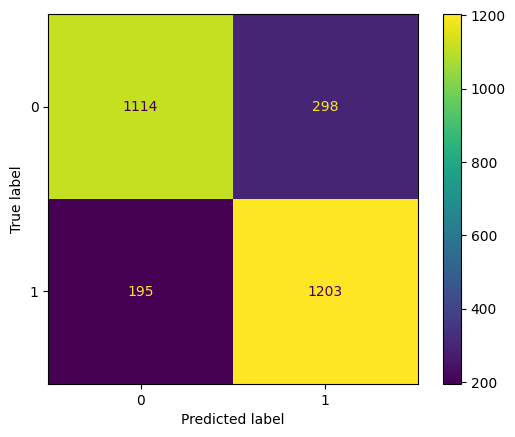

In [ ]:
# put your answer here
cm = confusion_matrix(Y_test, predictions)

 #Plot the confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

## E. Test the model

In [ ]:
# put your answer here
tfidf = TfidfVectorizer()
new_text = pd.Series("Ang init ng ulo ko ang gulo gulo ng paligid sarap talaga sumigaw ng putangina!")
tfidf.fit(preprocessed_text_1)

new_text_transform = tfidf.transform(new_text)
prediction = model.predict(new_text_transform)
if prediction == 1:
    print("hate speech")
else:
    print("non-hate speech")

hate speech
